# Fase 4.3

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
class_name = 'TRACK_genre_top_num'
df = pd.read_csv('flat_df_no_nulli_no_out.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli
df['TRACK_genre_top_num'] = [1 if genre == "Rock" else 0 for genre in df["TRACK_genre_top"]]

df

,track_id,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,...,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_,TRACK_genre_top_num
0,2,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,0.746760,1.335255,-0.069000,0.063224,-0.055764,0.206749,-0.152102,-0.075675,North America,0
1,3,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,1.221668,0.087193,-0.092808,-0.029543,0.014404,0.106603,-0.251621,-0.060280,North America,0
2,5,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,1.546327,3.707580,-0.159586,0.005594,-0.004815,0.052547,-0.209312,-0.052692,North America,0
3,10,2008.0,4.0,Album,[],2.0,47632.0,Constant Hitmaker,small,4.317488,...,1.987875,1.841458,-0.089548,-0.084626,0.077173,-0.015011,-0.360596,-0.026267,NaN,0
9,134,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,2.088149,6.580380,-0.146649,-0.041780,0.039949,0.023004,-1.213183,-0.056095,North America,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104466,155315,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.896165,-1.260438,-0.059327,0.022795,-0.011546,0.097424,0.618452,0.003335,North America,1
104467,155316,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-1.297131,-0.902569,-0.010471,0.090281,-0.104228,-0.123058,0.233260,0.021846,North America,1
104468,155317,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.528187,-1.008135,0.155377,-0.135316,0.154183,-0.131252,-0.439485,0.051446,North America,1
104469,155318,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-0.882132,-0.492957,0.030095,0.042125,-0.049494,-0.081322,-0.305773,-0.001345,North America,1


In [3]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop',
    'ALBUM_type_',
    'track_id'
]

attributi = [
    "mfccskew",
    "mfccmedian",
    "ALBUM_type_",
    "spectral_bandwidthmean01",
    "chroma_stftmedian",
    "mfccmax",
    "zcrstd01",
    "rmsekurtosis01",
    "ARTIST_favorites_",
    "spectral_centroidstd01",
    "ALBUM_date_released_year_",
    "zcrmedian01",
    "spectral_contrastmin",
    "chroma_cqtstd"
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_genre_top_num',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [4]:
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler

X = df[attributi].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

In [7]:
from sklearn.preprocessing import KBinsDiscretizer

In [64]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
Xt = est.fit_transform(X_scaled)

In [65]:
Xt

array([[1., 1., 1., ..., 0., 2., 2.],
       [1., 1., 2., ..., 0., 0., 2.],
       [1., 1., 1., ..., 0., 2., 1.],
       ...,
       [1., 1., 1., ..., 0., 2., 1.],
       [0., 1., 1., ..., 0., 2., 2.],
       [1., 1., 1., ..., 0., 2., 1.]])

In [66]:
est.bin_edges_

array([array([-6.60157999, -0.12484869,  6.35188262, 12.82861392, 19.30534523,
       25.78207653]),
       array([-3.08171308, -0.95915173,  1.16340963,  3.28597098,  5.40853234,
        7.53109369]),
       array([-2.82049265, -1.08573827,  0.64901611,  2.38377049,  4.11852487,
        5.85327925]),
       array([-3.36707276, -1.92835575, -0.48963874,  0.94907828,  2.38779529,
        3.8265123 ]),
       array([-2.50369798,  0.17633855,  2.85637508,  5.53641162,  8.21644815,
       10.89648468]),
       array([-1.43088865,  1.68196023,  4.7948091 ,  7.90765797, 11.02050684,
       14.13335572]),
       array([-9.47978529e-02,  3.60827087e+01,  7.22602152e+01,  1.08437722e+02,
        1.44615228e+02,  1.80792735e+02]),
       array([-0.28034841,  3.05014193,  6.38063227,  9.71112261, 13.04161294,
       16.37210328]),
       array([-1.87076244,  0.92768556,  3.72613357,  6.52458157,  9.32302958,
       12.12147759]),
       array([-25.26944064, -19.72231665, -14.17519266,  -8.6280686

## K-modes

In [77]:
from kmodes.kmodes import KModes


km = KModes(n_clusters=4, init='Huang', n_init=1, verbose=1)

clusters = km.fit_predict(Xt)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 13427, cost: 100637.0
Run 1, iteration: 2/100, moves: 1267, cost: 100637.0


In [80]:
km.cost_

100637.0

In [68]:
centroids = km.cluster_centroids_

In [69]:
clusters_df = pd.DataFrame({'Column0': centroids[:, 0], 'Column1': centroids[:, 1], 
                            'Column2': centroids[:, 2], 'Column3': centroids[:, 3],
                            'Column4': centroids[:, 4], 'Column5': centroids[:, 5],
                            'Column6': centroids[:, 6], 'Column7': centroids[:, 7],
                            'Column8': centroids[:, 8], 'Column9': centroids[:, 9],
                            'class': [0,1,2,3]})
clusters_df

,Column0,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,class
0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0
1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1
2,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,2
3,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0,3


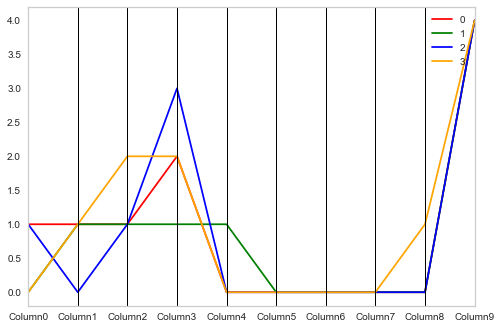

In [70]:
pd.plotting.parallel_coordinates(clusters_df, "class", color=["red", "green", "blue", "orange"]);

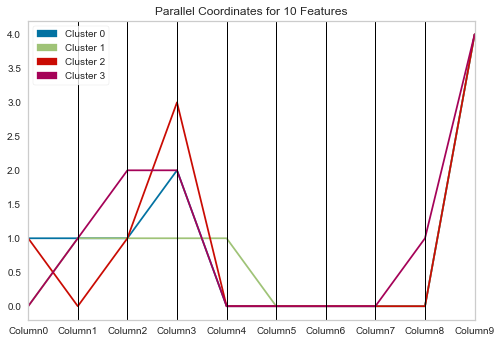

In [88]:
attributi = [
    "mfccskew",
    "mfccmedian",
    #"ALBUM_type_",
    "spectral_bandwidthmean01",
    "chroma_stftmedian",
    "mfccmax",
    "zcrstd01",
    "rmsekurtosis01",
    "ARTIST_favorites_",
    "spectral_centroidstd01",
    "ALBUM_date_released_year_",
    "zcrmedian01",
    "spectral_contrastmin",
    "chroma_cqtstd"
]
from yellowbrick.features.pcoords import parallel_coordinates

# Specify the features of interest and the classes of the target
features = [
    "Column0", "Column1", "Column2", "Column3", "Column4", "Column5", "Column6", "Column7", "Column8", "Column9"
]
classes = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]

# Instantiate the visualizer
visualizer = parallel_coordinates(clusters_df[features], clusters_df["class"], 
                                  alpha=1, classes=classes, features=features,
                                )

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9276, cost: 119396.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10662, cost: 130186.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7232, cost: 128163.0
Run 3, iteration: 2/100, moves: 2409, cost: 128163.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16247, cost: 118853.0
Run 1, iteration: 2/100, moves: 10902, cost: 117544.0
Run 1, iteration: 3/100, moves: 46, cost: 117544.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16830, cost: 113746.0
Run 2, iteration: 2/100, moves: 1996, cost: 113746.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1

AttributeError: 'KModes' object has no attribute 'k'

AttributeError: 'KModes' object has no attribute 'k'

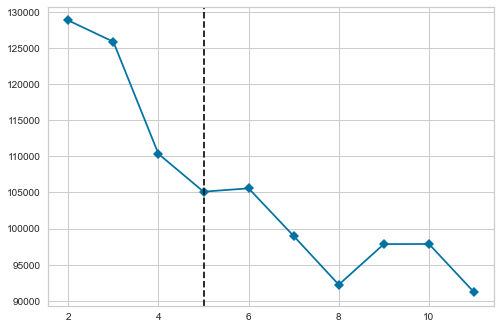

In [73]:
from yellowbrick.cluster import KElbowVisualizer

model = KModes(init='Huang', n_init=3, verbose=1)
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, locate_elbow=True, title=" ")

visualizer.fit(Xt)

In [89]:
K = range(2, 26, 2)
sse = []

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=3, verbose=1)
    km.fit(Xt)
    sse.append((k, km.cost_))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8780, cost: 121011.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 11013, cost: 119396.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5563, cost: 129278.0
Run 3, iteration: 2/100, moves: 2985, cost: 129278.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11402, cost: 106657.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12724, cost: 108580.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 15033, cost: 102950.0
Run 3, iteration: 2/100, moves: 4174, cost: 102950.0
Best run was number 3
Init: initializing centroids
Init: initializing 

AttributeError: module 'matplotlib.pyplot' has no attribute 'lenged'

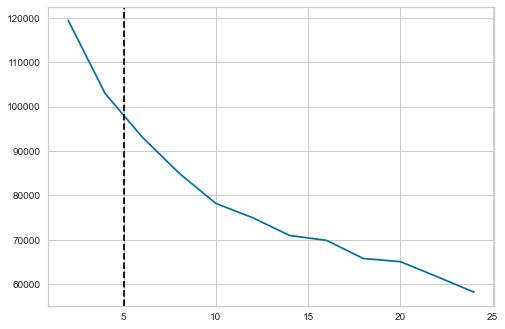

In [92]:
plt.plot(*zip(*sse))
plt.axvline(x=5, label='elbow at k=5',  ls='--', c='black')
plt.lenged()
plt.show()

## Rock

In [ ]:
from pyclustering.cluster import rock #LENTO

rc = rock.rock(X2[:100], eps=0.7, number_clusters=4, threshold=0.5)
rc.process()

In [ ]:
clusters = rc.get_clusters()